<a href="https://colab.research.google.com/github/michelle-manfrini/Forest-Cover-Classification/blob/main/Forest_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forest Cover Classification**

The goal of this prpject was to build a deep learning model that predicts the type of forest cover types based on different cartographic variables.

In [18]:
!pip install sweetviz

In [20]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [21]:
tf.get_logger().setLevel('ERROR')

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [36]:
from google.colab import files

uploaded = files.upload()


Saving cover_data.csv to cover_data (3).csv


In [23]:
def prep_data(raw_df):

    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

In [27]:
def build_model(num_features):

    classifier = keras.Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    classifier.add(layers.Dense(32, activation='relu'))
    classifier.add(layers.Dense(8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [44]:
def plot_heatmap(class_names, y_pred, y_test):

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)

    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig('heatmap.png')


In [46]:
def plot_history(history, param):

    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

In [49]:
def main():

  import io
  raw_df = pd.read_csv(io.BytesIO(uploaded['cover_data (3).csv']))

  # Exploratory Data Analysis - additional 10 minutes to run if desired
  my_report = sv.analyze(raw_df)
  my_report.show_html()

  cols = raw_df.columns.tolist()
  features, label = cols[:-1], cols[-1]
  X_train, X_test, y_train, y_test = prep_data(raw_df)

  num_features = len(features)
  model = build_model(num_features)

  print("Summary report of Keras classifier:")
  model.summary()

  num_epochs = 100
  batch_size = 1024
  earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
  history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

  plot_history(history, 'acc')
  plot_history(history, 'loss')

  score = model.evaluate(X_test, y_test, verbose=0)
  print(f'Test loss: {score[0]}')
  print(f'Test accuracy: {score[1]}')

  y_pred = model.predict(X_test)

  y_pred = np.argmax(y_pred, axis=1)
  class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
  print(classification_report(y_test, y_pred, target_names=class_names))
  plot_heatmap(class_names, y_pred, y_test)

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Summary report of Keras classifier:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                3520      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
Total params: 5864 (22.91 KB)
Trainable params: 5864 (22.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
409/409 [==============================] - 2s 4ms/step - loss: 0.7883 - accur

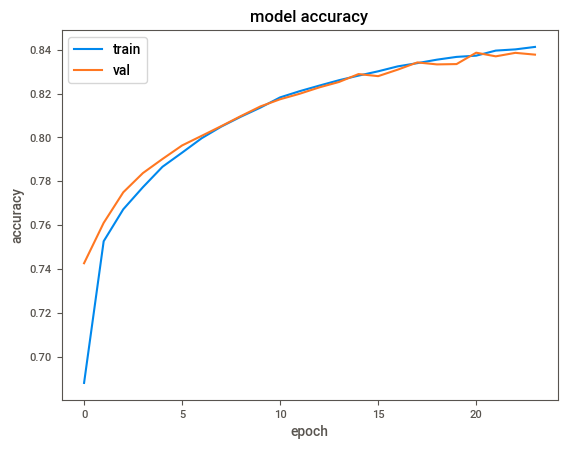

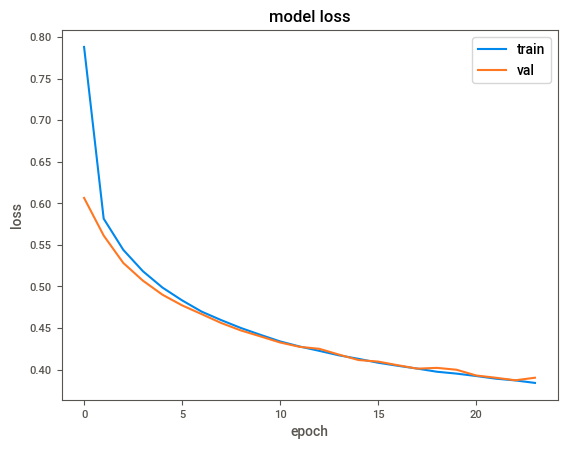

Test loss: 0.3910006880760193
Test accuracy: 0.839496374130249
3632/3632 [==============================] - 4s 1ms/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.88      0.78      0.83     42368
   Lodgepole Pine       0.83      0.92      0.87     56661
   Ponderosa Pine       0.79      0.83      0.81      7151
Cottonwood/Willow       0.78      0.62      0.69       549
            Aspen       0.72      0.39      0.50      1899
      Douglas-fir       0.68      0.55      0.61      3473
        Krummholz       0.90      0.81      0.85      4102

         accuracy                           0.84    116203
        macro avg       0.80      0.70      0.74    116203
     weighted avg       0.84      0.84      0.84    116203



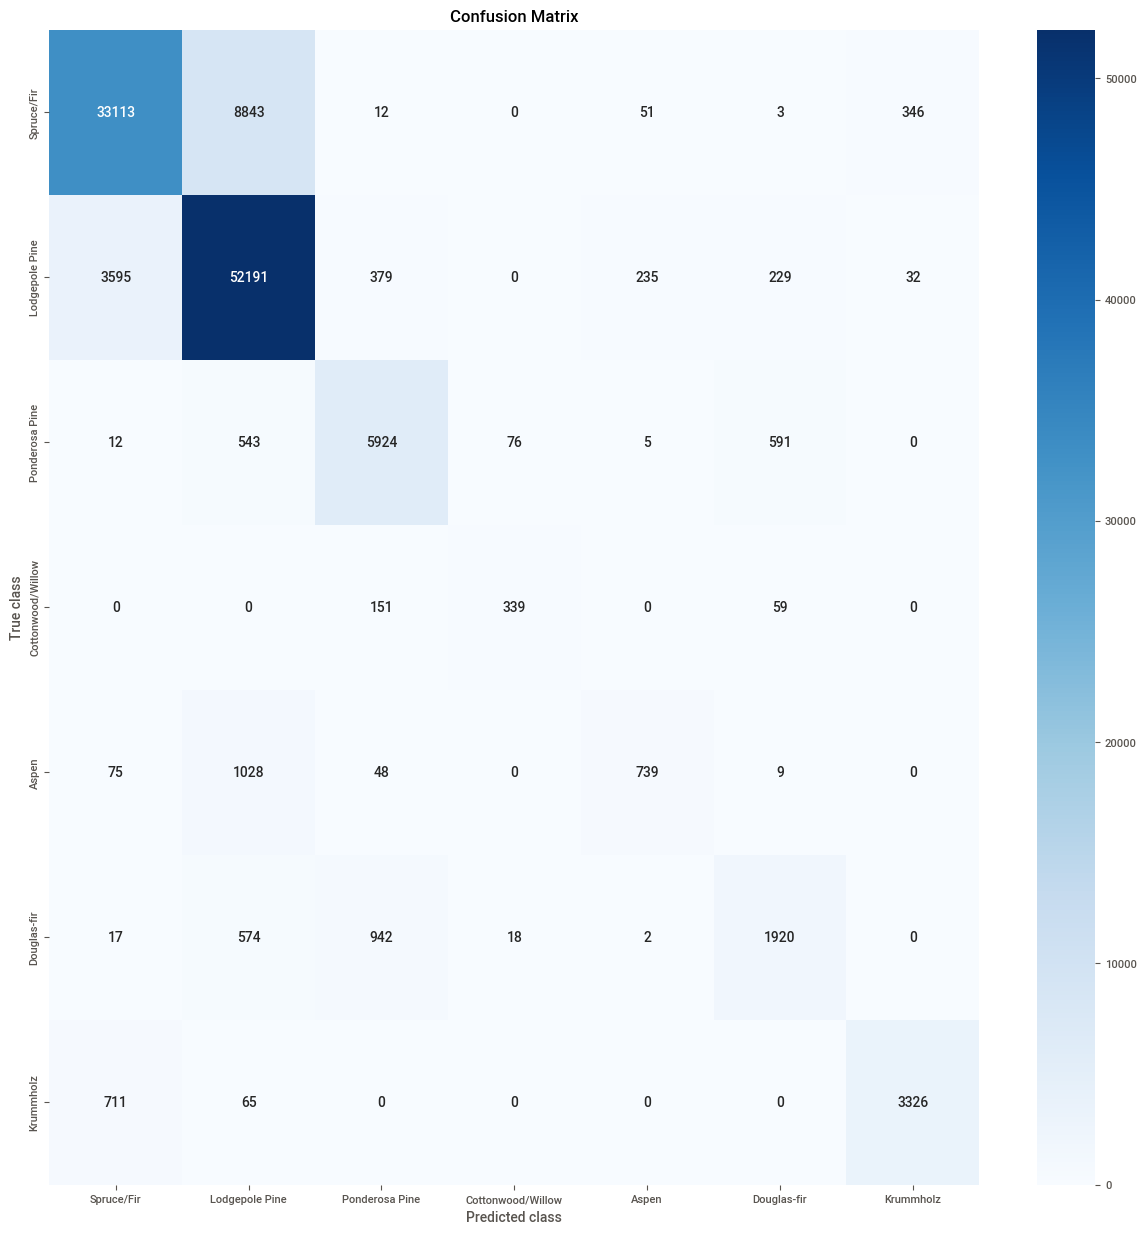

In [50]:
if __name__ == '__main__':
    main()

The purpose of the heatmap is to show the number of correct classifications on the diagonal. The incorrect classifications are shown on the sides of the diagonal, revealing that Cottonwood Willow, Aspen, Lodgepole Pine, and Douglas-Fir have the highest percentage.

